<a href="https://colab.research.google.com/github/porhJ/UAV-Suspended-Load-Control/blob/main/perfect_drone_dance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

In [4]:
from scipy.linalg import solve_discrete_are

$\underline q$ = $[x, z, \theta_d, \theta_p]$

# Simple case

- y = x
- no delay, friction

im gonna finish this rq, trust me

starting time: 13:11

In [ ]:
class PackagingDroneSimple():
  def __init__(self, m_d, m_p, Id_cm, r_d, l, x_ref_, u_ref_, g = 9.8):
    self.m_d = m_d
    self.Id_cm = Id_cm
    self.r_d = r_d
    self.m_p = m_p
    self.l = l
    self.x_ref_ = x_ref_
    self.dx_ref_ = np.array([0, 0, 0, 0])
    self.u_ref_ = u_ref_
    self.g = g

  def dynamics(self, x_, u_):
    x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_

    # frm M * ddq + C * dq = tau_g + Bu
    # its actually just newton's 2nd law but fancy
    # M is mass matrix (or intertia if it is in theta coordinate)
    # Thus force = tau_g + Bu - C * dq
    # So F = Ma where a is obviously ddq
    # tau_g + Bu - C * dq = M * ddq

    M = np.array([[self.m_p + self.m_d, 0, 0, self.m_p * self.l * np.cos(theta_p)],
                  [0, self.m_p + self.m_d, 0, self.m_p * self.l * np.sin(theta_p)],
                  [0, 0, self.Id_cm, 0],
                  [self.m_p * self.l * np.cos(theta_p), self.m_p * self.l * np.sin(theta_p), 0, self.m_p * (self.l ** 2)]])

    C = np.array([[0, 0, 0, -self.l * dtheta_p * np.sin(theta_p)],
                  [0, 0, 0, self.l * dtheta_p * np.cos(theta_p)],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])

    tau_g = np.array([[0, -(self.m_p + self.m_d) * self.g, 0, -self.m_p * self.g * self.l * np.sin(theta_p)]])
    tau_g = tau_g.T
    B = np.array([[np.cos(theta_d), np.cos(theta_d)],
                  [np.sin(theta_d), np.sin(theta_d)],
                  [self.r_d, -self.r_d],
                  [0, 0]])

    q_dot = np.array([[dx, dz, dtheta_d, dtheta_p]])
    q_dot = q_dot.T

    force = tau_g + B @ u_ - C @ q_dot
    # we want ddq, thus we use inv(M), but this is lowkey unsafe, so we just gonna use np.linalg.solve, it is safer. source: trust me bro
    ddq = np.linalg.solve(M, force).flatten()
    ddx, ddz, ddtheta_d, ddtheta_p = ddq

    # we gonna return dx_
    return np.array([dx, ddx, dz, ddz, dtheta_d, ddtheta_d, dtheta_p, ddtheta_p])

  def get_jacobian(self, eps = 1e-6):
    n = len(self.x_ref_)
    m = 2
    A = np.zeros((n, n))
    B = np.zeros((n, m))
    f0 = self.dynamics(self.x_ref_, self.u_ref_)

    for i in range(n):
      y_perturb = self.x_ref_.copy()
      y_perturb[i] += eps
      f_perturb = self.dynamics(y_perturb, self.u_ref_)
      A[:, i] = (f_perturb - f0) / eps

    for j in range(m):
      u_perturb = self.u_ref_.copy()
      u_perturb[j] += eps
      f_perturb_u = self.dynamics(self.x_ref_, u_perturb)
      B[:, j] = (f_perturb_u - f0) / eps

    return A, B

  def linearized_dynamics(self, x_, u_, A, B):
    delta_x_ = x_ - self.x_ref_
    delta_u_ = u_ - self.u_ref_
    delta_dx_ = A @ delta_x_ + B @ delta_u_
    dx_ = self.dx_ref_ + delta_dx_
    return dx_

  def control_law(self, x_, int_, kr_, ki_):
    error_x = (x_ - self.x_ref_).reshape(-1, 1)
    error_int = int_.reshape(-1, 1)
    delta_u = - kr_ @ error_x + ki_ @ error_int
    return self.u_ref_ + delta_u

  def get_kr_ (self, A, B, Q, R):
    P = solve_continuous_are(A, B, Q, R)
    return np.linalg.inv(R) @ B.T @ P

  def step(self, x_, kr_, ki_ , A, B, int_, dt = 1.0e-3):
    int_ += (self.x_ref_ - x_) * dt
    u_ = self.control_law(x_, int_, kr_, ki_)
    dx_ = self.dynamics(x_, u_)
    return x_ + dx_ * dt, int_

In [ ]:
m_d = 5
m_p = 2
M = m_d + m_p
g = 9.8
r_d = 0.5
Id_cm = 1/12 * m_d * (2 * r_d) ** 2
l = 1.5
x_ref = 10
z_ref = 5
x_ref_ = np.array([x_ref, 0, z_ref, 0, 0.5 * np.pi, 0, 0, 0])
u_ref_ = np.array([[0.5 * M * g, 0.5 * M * g]])
u_ref_ = u_ref_.T
ki_ = np.array([[1.0, 0, 5, 0, 0, 0, 0, 0],
                [1.0, 0, 5, 0, 0, 0, 0, 0]])
int_ = 0

$x_{ref} = [x, \dot{x}, z, \dot{z}, \theta_d, \dot{\theta_d}, \theta_p, \dot{\theta_p}]$

In [ ]:
Q = np.diag([20, 1, 5, 1, 50, 1, 50, 1])
R = np.diag([0.01, 0.01])

In [ ]:
pkgDroneSys = PackagingDroneSimple(m_d, m_p, Id_cm, r_d, l, x_ref_,  u_ref_)

In [ ]:
A, B = pkgDroneSys.get_jacobian()

In [ ]:
Kr = pkgDroneSys.get_kr_(A, B, Q, R)

In [ ]:
x_ = np.array([0, 0, 2, 0, np.pi - 1.0e-3, 0, 0 + 1.0e-3, 0])

In [ ]:
int_ = 0

In [ ]:
hist = []

In [ ]:
x_hist = []
dx_hist = []
z_hist = []
dz_hist = []
theta_d_hist = []
dtheta_d_hist = []
theta_p_hist = []
dtheta_p_hist = []

In [ ]:
# x_hist, dx_hist, z_hist, dz_hist, theta_d_hist, dtheta_d_hist, theta_p_hist, dtheta_p_hist

In [ ]:
t_terminate = 0

In [ ]:
for step in range(20000):
  x_, int_ = pkgDroneSys.step(x_, Kr, ki_, A, B, int_)
  hist.append(x_)
  x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_
  theta_d = np.arctan2(np.sin(theta_d), np.cos(theta_d))
  theta_p = np.arctan2(np.sin(theta_p), np.cos(theta_p))
  x_hist.append(x)
  dx_hist.append(dx)
  z_hist.append(z)
  dz_hist.append(dz)
  theta_d_hist.append(theta_d)
  dtheta_d_hist.append(dtheta_d)
  theta_p_hist.append(theta_p)
  dtheta_p_hist.append(dtheta_p)
  if abs(x - x_ref) < 0.5 and abs(z - z_ref) < 0.5 :
    t_terminate = step

In [ ]:
hist[0]

array([ 0.00000000e+00, -3.27036256e-02,  2.00000000e+00, -9.78598413e-03,
        3.14059265e+00, -1.17368326e+00,  1.00000000e-03,  2.18023968e-02])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
x_ref_

array([10.        ,  0.        ,  5.        ,  0.        ,  1.57079633,
        0.        ,  0.        ,  0.        ])

In [ ]:
def plot_drone_LQR(
    states, t_terminate, Q, R
):
    fig, ax = plt.subplots(figsize=(12, 8))
    for state_name, state in states.items():
      state_hist, state_eq = state
      plt.plot(state_hist, label=f"{state_name}")
      plt.axhline(y=state_eq, linestyle="--", label=f"{state_name} equilibrium at {state_eq}")
    plt.title("Inverted Pendulum LQR-Control")
    plt.axvline(
        x=t_terminate, color="g", linestyle="--", label=f"Reach final point time (x={t_terminate})"
    )
    fig = plt.gcf()
    fig.text(
        0.5,
        0.005,
        f"Q = diag({np.diag(Q)})    R = diag({np.diag(R)})",
        ha="center",
        va="bottom",
        fontsize=9,
    )
    plt.xlabel("Time Steps")
    plt.legend()
    Q_vals = "_".join(f"{v:g}" for v in np.diag(Q))
    R_vals = "_".join(f"{v:g}" for v in np.diag(R))

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.figtext(0.5, 0.01, "Q = diag(...)  R = diag(...)", ha="center", fontsize=10)
    plt.subplots_adjust(right=0.75, bottom=0.15)
    plt.show()

In [ ]:
states_hist = [x_hist, dx_hist, z_hist, dz_hist, theta_d_hist, dtheta_d_hist, theta_p_hist, dtheta_p_hist]

In [ ]:
states_name = ["x", "dx", "z", "dz", "theta_d", "dtheta_d", "theta_p", "dtheta_p"]

In [ ]:
states = {}

In [ ]:
n = len(states_hist)
for i in range(n):
  states[f"{states_name[i]}"] = [states_hist[i], x_ref_[i]]

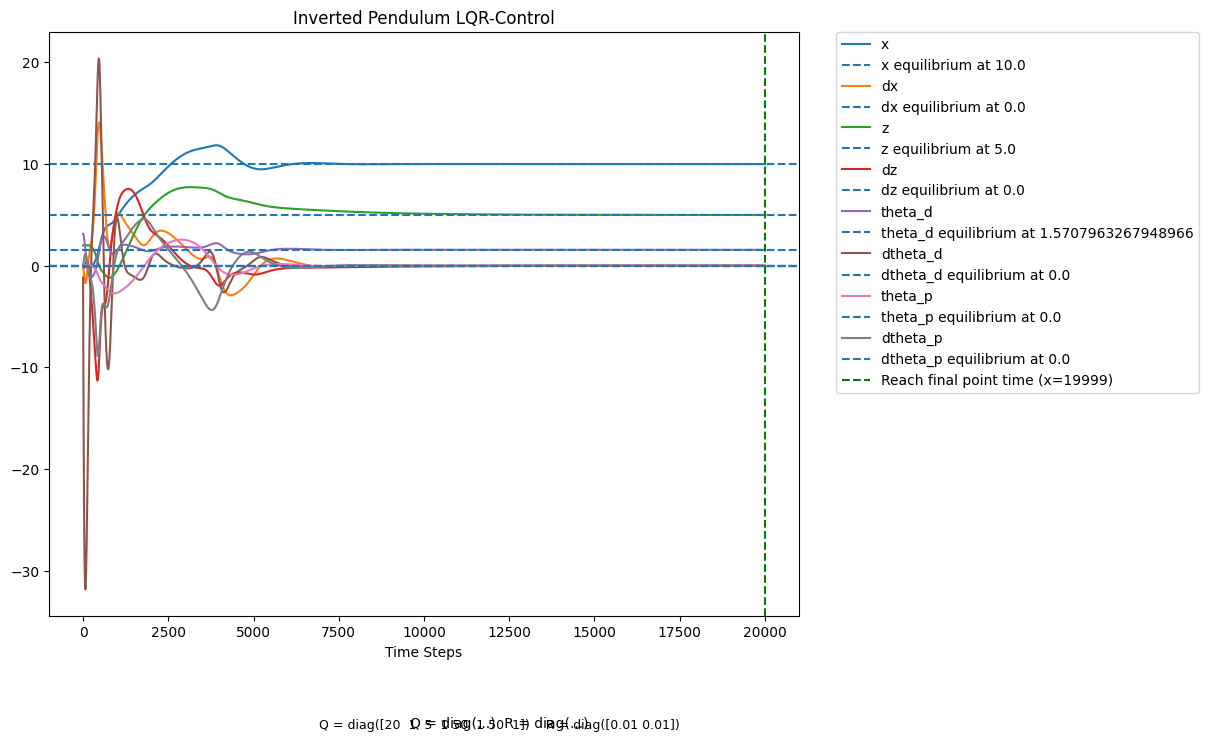

In [ ]:
plot_drone_LQR(states, t_terminate, Q, R)

In [ ]:
!pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 8.5 MB/s eta 0:00:00


In [ ]:
import control as ctrl

In [ ]:
C = np.array([[1, 0, 1, 0, 1, 0, 1, 0]])

In [ ]:
C = C.T

In [ ]:
A

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.37200000e+01,  0.00000000e+00,
         3.92000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -4.90071475e-06,  0.00000000e+00,
         3.92000000e-06, -2.14285714e-07],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.000000

In [ ]:
O = ctrl.obsv(A, C)

In [ ]:
C = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],  # Row 1: Measures x
    [0, 0, 1, 0, 0, 0, 0, 0]   # Row 2: Measures z
])

In [ ]:
C.shape

(2, 8)

In [ ]:
n = A.shape[0]

In [ ]:
rank_O

np.int64(6)

In [ ]:
n

8

In [ ]:
import numpy as np
from scipy.linalg import null_space

# 1. Your System
# Replace these with your ACTUAL A and C
n = 8
# 2. Build Observability Matrix
O_list = [C]
for i in range(1, n):
    O_list.append(C @ np.linalg.matrix_power(A, i))
O = np.vstack(O_list)

# 3. Check Rank
rank = np.linalg.matrix_rank(O)
print(f"Rank: {rank}/{n}")

# 4. THE MAGIC STEP: Find the Invisible States
# Calculate the Null Space (Kernel) of O
# These vectors point to exactly what you can't see.
null_vectors = null_space(O)

print("\nThe 'Ghost' Directions (Unobservable States):")
print(null_vectors)

# Interpret the result
# If null_vectors has a '1' in row 0 and '0' everywhere else,
# it means State 0 (index 0) is unobservable.

Rank: 8/8

The 'Ghost' Directions (Unobservable States):
[]


# Dynamics code

This code is for simulation the drone-suspended-payload system

where state is
$$\underline{x} = [x, \dot{x}, z, \dot{z}, \theta_d, \dot{\theta_d}, \theta_p, \dot{\theta_p}]$$

In [5]:
import numpy as np


class PackageDroneIdealDynamics:
    def __init__(self, m_d, m_p, Id_cm, r_d, l, x_ref_, u_ref_, g=9.8):
        self.m_d = m_d
        self.Id_cm = Id_cm
        self.r_d = r_d
        self.m_p = m_p
        self.l = l
        self.x_ref_ = x_ref_
        self.dx_ref_ = np.array([0, 0, 0, 0])
        self.u_ref_ = u_ref_
        self.g = g

    def dynamics(self, x_, u_):
        x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_

        # frm M * ddq + C * dq = tau_g + Bu
        # its actually just newton's 2nd law but fancy
        # M is mass matrix (or intertia if it is in theta coordinate)
        # Thus force = tau_g + Bu - C * dq
        # So F = Ma where a is obviously ddq
        # tau_g + Bu - C * dq = M * ddq

        M = np.array(
            [
                [self.m_p + self.m_d, 0, 0, self.m_p * self.l * np.cos(theta_p)],
                [0, self.m_p + self.m_d, 0, self.m_p * self.l * np.sin(theta_p)],
                [0, 0, self.Id_cm, 0],
                [
                    self.m_p * self.l * np.cos(theta_p),
                    self.m_p * self.l * np.sin(theta_p),
                    0,
                    self.m_p * (self.l**2),
                ],
            ]
        )

        C = np.array(
            [
                [0, 0, 0, -self.l * dtheta_p * np.sin(theta_p)],
                [0, 0, 0, self.l * dtheta_p * np.cos(theta_p)],
                [0, 0, 0, 0],
                [0, 0, 0, 0],
            ]
        )

        tau_g = np.array(
            [
                [
                    0,
                    -(self.m_p + self.m_d) * self.g,
                    0,
                    -self.m_p * self.g * self.l * np.sin(theta_p),
                ]
            ]
        )
        tau_g = tau_g.T
        B = np.array(
            [
                [np.cos(theta_d), np.cos(theta_d)],
                [np.sin(theta_d), np.sin(theta_d)],
                [self.r_d, -self.r_d],
                [0, 0],
            ]
        )

        q_dot = np.array([[dx, dz, dtheta_d, dtheta_p]])
        q_dot = q_dot.T

        force = tau_g + B @ u_ - C @ q_dot
        # we want ddq, thus we use inv(M), but this is lowkey unsafe, so we just gonna use np.linalg.solve, it is safer. source: trust me bro
        ddq = np.linalg.solve(M, force).flatten()
        ddx, ddz, ddtheta_d, ddtheta_p = ddq

        # we gonna return dx_
        return np.array([dx, ddx, dz, ddz, dtheta_d, ddtheta_d, dtheta_p, ddtheta_p])

    def get_jacobian(self, x_, u, eps=1e-6):
        n = len(x_)
        m = 2
        Df_Dx = np.zeros((n, n))
        B = np.zeros((n, m))
        f0 = self.dynamics(x_, u)

        for i in range(n):
            y_perturb = x_.copy()
            y_perturb[i] += eps
            f_perturb = self.dynamics(y_perturb, u)
            Df_Dx[:, i] = (f_perturb - f0) / eps

        for j in range(m):
            u_perturb = self.u_ref_.copy()
            u_perturb[j] += eps
            f_perturb_u = self.dynamics(x_, u_perturb)
            B[:, j] = (f_perturb_u - f0) / eps

        return Df_Dx, B

    def linearized_dynamics(self, x_, u_, A, B):
        delta_x_ = x_ - self.x_ref_
        delta_u_ = u_ - self.u_ref_
        delta_dx_ = A @ delta_x_ + B @ delta_u_
        dx_ = self.dx_ref_ + delta_dx_
        return dx_

# Visualization code

In [172]:
import math

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from matplotlib.patches import Polygon

def plot_state_history(
    hist,
    hist_hat=None,
    t=None,
    state_names=None,
    figsize=(12, 8),
    sharex=True,
    plot_error=False,
    markers_every=None,
    savepath=None,
):
    """
    plot a lot of graphs:
        1. RMSE
        2. error of each variable vs time
        3. true vs estimate of each variable
    I vibed this, edited it, and now it is beautiful.
    """

    hist = np.asarray(hist)
    T, n = hist.shape
    if hist_hat is not None:
        hist_hat = np.asarray(hist_hat)
        assert hist_hat.shape == (T, n), "hist_hat shape must match hist"
    if t is None:
        t = np.arange(T)
    else:
        t = np.asarray(t)
        assert len(t) == T

    if state_names is None:
        state_names = [f"s{i}" for i in range(n)]
    assert len(state_names) == n

    ncols = 2 if n > 3 else 1
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=sharex)
    # axes can be 2D/1D scalar -- normalize to 1D list
    if nrows * ncols == 1:
        axes = np.array([axes])
    else:
        axes = axes.flatten()




    for i in range(n):
        ax = axes[i]
        ax.plot(t, hist[:, i], "-", label="true")
        if hist_hat is not None:
            ax.plot(t, hist_hat[:, i], "--", label="est")
        if markers_every is not None and markers_every > 0:
            ax.plot(t[::markers_every], hist[::markers_every, i], "o", markersize=3)
            if hist_hat is not None:
                ax.plot(
                    t[::markers_every], hist_hat[::markers_every, i], "x", markersize=3
                )

        ax.set_ylabel(state_names[i])
        ax.grid(True)
        ax.legend(loc="upper right", fontsize="small")

    # hide any unused subplots
    for j in range(n, len(axes)):
        axes[j].axis("off")

    if sharex:
        axes[-1].set_xlabel("time (step)" if t is None else "time")

    plt.tight_layout()
    if savepath:
        fig.savefig(f"{savepath}_states.png", dpi=200)

    if plot_error and hist_hat is not None:
        errors = hist - hist_hat  # shape (T, n)
        fig2, ax2 = plt.subplots(figsize=(max(8, ncols * 4), 4))
        # plot each error with small alpha to keep it compact
        for i in range(n):
            ax2.plot(t, errors[:, i], label=state_names[i], linewidth=0.9)
        ax2.set_title("Estimation error (true - est)")
        ax2.set_xlabel("time")
        ax2.grid(True)
        ax2.legend(ncol=min(4, n), fontsize="small", loc="upper right")
        plt.tight_layout()
        if savepath:
            fig2.savefig(f"{savepath}_errors.png", dpi=200)

    if hist_hat is not None:
        rmse = np.sqrt(((hist - hist_hat) ** 2).mean(axis=0))
        fig3, ax3 = plt.subplots(figsize=(max(8, ncols * 4), 3))
        ax3.bar(np.arange(n), rmse)
        ax3.set_xticks(np.arange(n))
        ax3.set_xticklabels(state_names, rotation=45, ha="right")
        ax3.set_ylabel("RMSE")
        ax3.set_title("Per-state RMSE")
        plt.tight_layout()
        if savepath:
            fig3.savefig(f"{savepath}_rmse.png", dpi=200)

    x_hist = hist[:, 0]
    z_hist = hist[:, 2]

    fig4, ax4 = plt.subplots(figsize=figsize)
    ax4.set_title("Trajectory path")
    ax4.set_xlabel("x")
    ax4.set_ylabel("z")
    ax4.grid(True)
    ax4.axis("equal")
    ax4.scatter(x_hist[-1], z_hist[-1], color="r")
    ax4.plot(x_hist, z_hist)

    plt.show()

# Controller

In [7]:
import numpy as np
from scipy.linalg import solve_discrete_are


class lqr_controller:
    def __init__(self, x_ref_, u_ref_, A, B, Ki):
        self.x_ref_ = x_ref_
        self.u_ref_ = u_ref_
        self.A = A
        self.B = B
        self.Ki = Ki

    def get_Kr_(self, A, B, Q, R):
        P = solve_discrete_are(A, B, Q, R)
        return np.linalg.inv(R) @ B.T @ P

    def control_law(self, x_, int_, Kr):
        error_x = (x_ - self.x_ref_).reshape(-1, 1)
        error_int = int_.reshape(-1, 1)
        delta_u = -Kr @ error_x + self.Ki @ error_int
        return self.u_ref_ + delta_u

    def step(self, system, x_, Kr, int_, dt=1.0e-3):
        int_ += (self.x_ref_ - x_) * dt
        u_ = self.control_law(x_, int_, Kr)
        dx_ = system.dynamics(x_, u_)
        return x_ + dx_ * dt, int_


# Setup

In [147]:
SEED = 42
rng = np.random.default_rng(seed=SEED)

In [148]:
m_d = 5
m_p = 2
M = m_d + m_p
g = 9.8
r_d = 0.5
Id_cm = 1 / 12 * m_d * (2 * r_d) ** 2
l = 0.5
x_ref = 5
z_ref = 5
x_ref_ = np.array([x_ref, 0, z_ref, 0, 0.5 * np.pi, 0, 0, 0])
u_ref_ = np.array([[0.5 * M * g, 0.5 * M * g]])
u_ref_ = u_ref_.T
Ki = np.array([[0, 0, 5, 0, 0, 0, 0, 0], [0, 0, 5, 0, 0, 0, 0, 0]])
int_ = 0
int_ = 0
t_terminate = 0
dt = 1.0e-3
systemDynamics = PackageDroneIdealDynamics(m_d, m_p, Id_cm, r_d, l, x_ref_, u_ref_)
A, B = systemDynamics.get_jacobian(x_ref_, u_ref_)
A = np.eye(len(A)) + A * dt
B = B * dt
C = np.array(
    [
        [1, 0, 0, 0, 0, 0, 0, 0],  # sensor for x
        [0, 0, 1, 0, 0, 0, 0, 0],  # sensor for z
        [0, 0, 0, 0, 1, 0, 0, 0],  # imu
    ]
)
# if using C = [1, 0, 1, 0, 0, 0, 0, 0], it implies =Nonethat it is one sensor that can measure both x and z, the rank will be insufficient.
# and that is NOT smart at alllllllllllllllll yoooooooooooooo

# Experiment

## Baseline
- No disturbance, only sensors noise
- Hovering
- Small Initial $\theta_p$ = 0.05 rad
- R_noise_x = 0.8^2 (based on u-blox NEO-M8N)
- R_noise_z = 0.1^2 (based on Bosch BMP388 / BMP390)
- R_noise_imu = 0.02^2 (based on Bosch BMI088)
- start at (0, 0) -> (5, 5)

In [149]:
Q_noise = np.eye(8) * 0.001
R_noise = np.diag([0.8**2, 0.1**2, 0.02**2])

Q, R intuition
- Qₓ, Q_z: penalize position error; higher → faster convergence, but too high → aggressive maneuvers and larger payload swing.

- Q_{vₓ}, Q_{v_z}: penalize speed; higher → safer for payload (limits induced swing) and reduces overshoot.

- Q_{θ_d}, Q_{ω_{θ_d}}: keep drone attitude near horizontal; penalize large tilt and fast attitude changes to avoid motor saturation and structural stress.

- Q_{θ_p}, Q_{ω_{θ_p}}: highest priority if you want to protect the package. Penalize payload angle strongly (θ_p) and its rate to prevent oscillation.

- R (u₁,u₂): penalize actuator effort. Larger R → smoother, safer thrusts; smaller R → more aggressive control. Keep R so commanded thrusts remain within physical bounds (no motor saturation).

In [177]:
Q = np.diag([25, 20, 25, 20, 15, 10, 30, 10])
R = np.diag([0.5, 0.5])

In [178]:
lqr = lqr_controller(x_ref_, u_ref_, A, B, Ki)
Kr = lqr.get_Kr_(A, B, Q, R)
x_ = np.array([0, 0, 0, 0, 0.25 * np.pi - 1.0e-3, 0, 0 + 1.0e-3, 0])
x_hat_ = np.array(
    [0, 0, 0, 0, 0.25 * np.pi, 0, 0, 0]
)  # initial estmated x
P = np.eye(8) * 0.1
# main loop
int_ = np.zeros_like(x_)
steps = 20000
hist = []
hist_hat = []
t_terminate = 0

In [179]:
for step in range(steps):
    # in controller, it shouldnt have access to the world, it should only know what it can percieve by sensors
    int_ += (x_ref_ - x_hat_) * dt
    u_ = lqr.control_law(x_hat_, int_, Kr)
    dx_hat_pred = systemDynamics.dynamics(x_hat_, u_)
    x_hat_pred_ = x_hat_ + dx_hat_pred * dt
    Df_Dx, _ = systemDynamics.get_jacobian(x_hat_, u_)
    F = np.eye(8) + Df_Dx * dt

    P_pred = F @ P @ F.T + Q_noise

    # simulation, this is the real world
    dx_ = systemDynamics.dynamics(x_, u_)
    x_ += dx_ * dt
    # x_ += np.random.normal(0, 0.001, size=8)

    # measure
    sigma = np.array([0.8, 0.1, 0.02])
    sensor_noise = rng.normal(0, sigma)
    y_ = C @ x_ + sensor_noise
    y_err_ = y_ - (C @ x_hat_pred_)
    S = C @ P_pred @ C.T + R_noise
    Kf = P_pred @ C.T @ np.linalg.solve(S, np.eye(len(S)))

    x_hat_ = x_hat_pred_ + Kf @ y_err_
    P = (np.eye(8) - Kf @ C) @ P_pred

    # remember the past ahh code
    # karn dern tarng korng chun lae ther kue karn rien ruuuu ahh
    x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_
    x_hat, _, z_hat, _, theta_d_hat, _, theta_p_hat, _ = x_hat_
    hist.append(x_.copy())
    hist_hat.append(x_hat_.copy())

    if abs(x - x_ref) < 0.001 and abs(z - z_ref) < 0.001 and t_terminate == 0:
        t_terminate = step

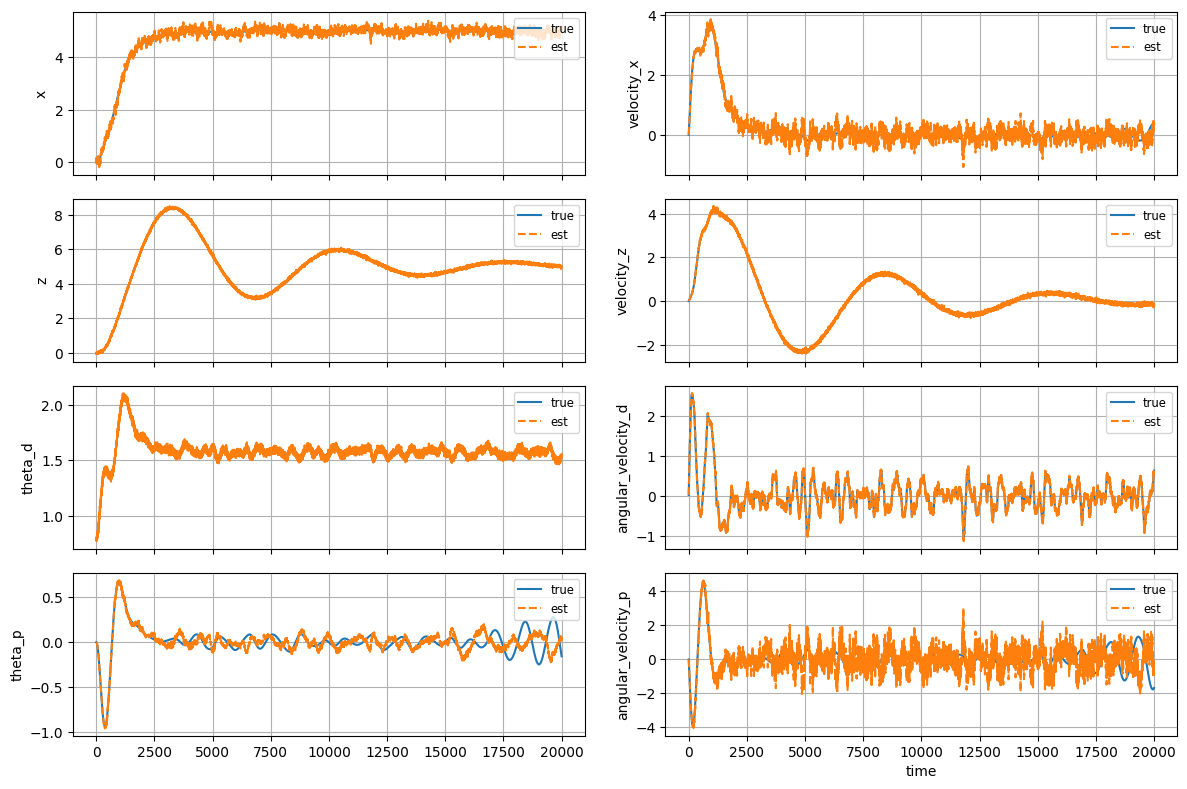

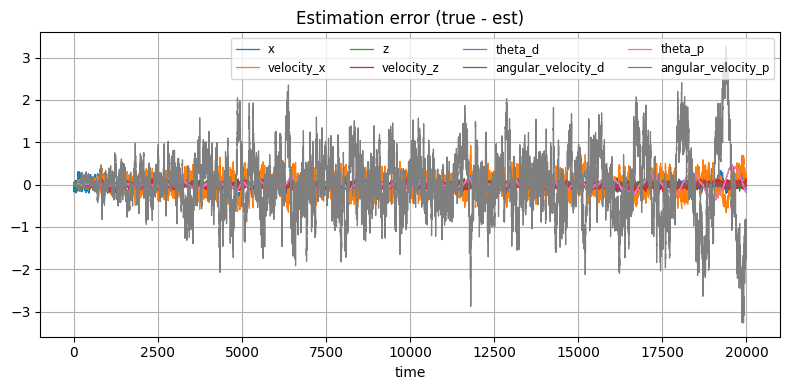

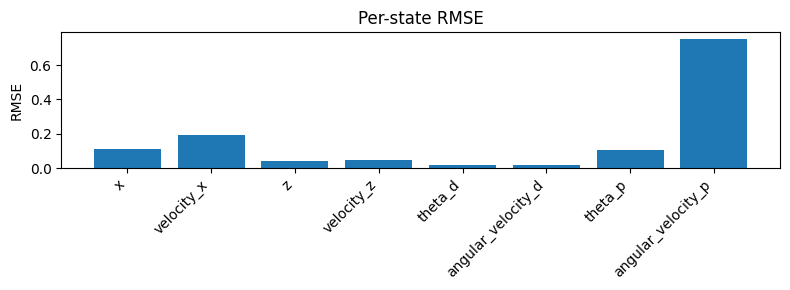

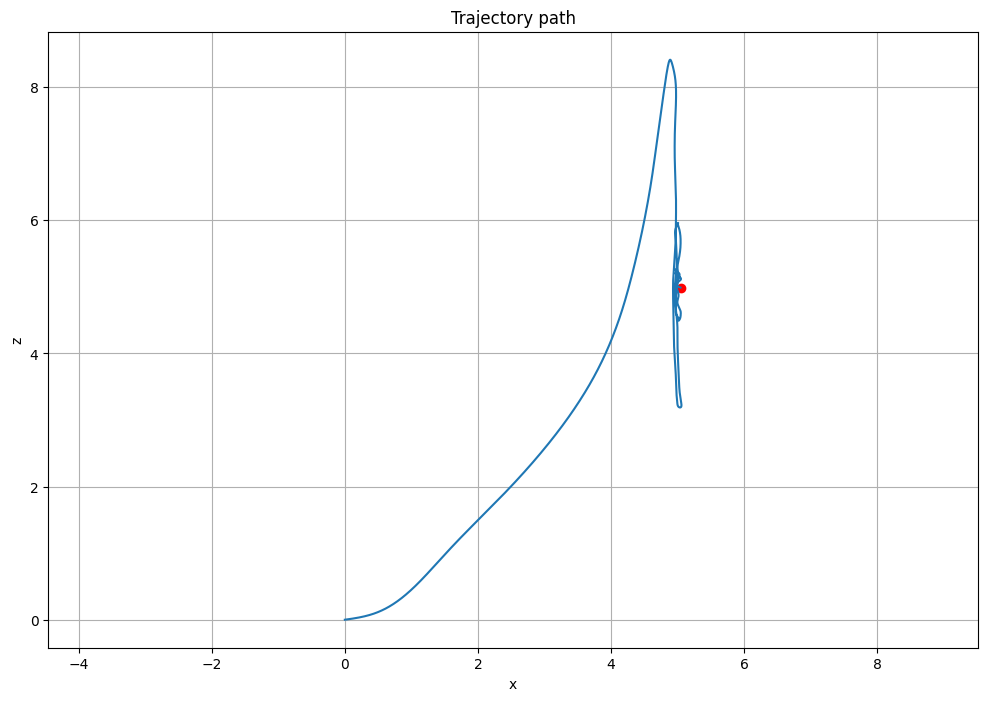

In [180]:
hist = np.array(hist)
hist_hat = np.array(hist_hat)

hist[:, 4] = np.arctan2(np.sin(hist[:, 4]), np.cos(hist[:, 4]))
hist[:, 6] = np.arctan2(np.sin(hist[:, 6]), np.cos(hist[:, 6]))

hist_hat[:, 4] = np.arctan2(np.sin(hist_hat[:, 4]), np.cos(hist_hat[:, 4]))
hist_hat[:, 6] = np.arctan2(np.sin(hist_hat[:, 6]), np.cos(hist_hat[:, 6]))


states_name = [
    "x",
    "velocity_x",
    "z",
    "velocity_z",
    "theta_d",
    "angular_velocity_d",
    "theta_p",
    "angular_velocity_p",
]

plot_state_history(hist, hist_hat, state_names=states_name, plot_error=True)

In [175]:
hist[-1, 0]

np.float64(5.03628890432531)

In [176]:
hist[-1, 2]

np.float64(4.767428850387421)

### Failure case
- Overpenalize theta_p state over position states leads to aggressive control. This pushes the system outside the validity region of the linearized model, resulting in instability despite correct linearization and estimation.

In [150]:
Q = np.diag([1, 0.5, 5, 1, 8, 1, 80, 10])
R = np.diag([0.5, 0.5])

In [151]:
lqr = lqr_controller(x_ref_, u_ref_, A, B, Ki)
Kr = lqr.get_Kr_(A, B, Q, R)
x_ = np.array([0, 0, 0, 0, 0.25 * np.pi - 1.0e-3, 0, 0 + 1.0e-3, 0])
x_hat_ = np.array(
    [0, 0, 0, 0, 0.25 * np.pi, 0, 0, 0]
)  # initial estmated x
P = np.eye(8) * 0.1
# main loop
int_ = np.zeros_like(x_)
steps = 20000
hist = []
hist_hat = []
t_terminate = 0

In [152]:
for step in range(steps):
    # in controller, it shouldnt have access to the world, it should only know what it can percieve by sensors
    int_ += (x_ref_ - x_hat_) * dt
    u_ = lqr.control_law(x_hat_, int_, Kr)
    dx_hat_pred = systemDynamics.dynamics(x_hat_, u_)
    x_hat_pred_ = x_hat_ + dx_hat_pred * dt
    Df_Dx, _ = systemDynamics.get_jacobian(x_hat_, u_)
    F = np.eye(8) + Df_Dx * dt

    P_pred = F @ P @ F.T + Q_noise

    # simulation, this is the real world
    dx_ = systemDynamics.dynamics(x_, u_)
    x_ += dx_ * dt
    # x_ += np.random.normal(0, 0.001, size=8)

    # measure
    sigma = np.array([0.8, 0.1, 0.02])
    sensor_noise = rng.normal(0, sigma)
    y_ = C @ x_ + sensor_noise
    y_err_ = y_ - (C @ x_hat_pred_)
    S = C @ P_pred @ C.T + R_noise
    Kf = P_pred @ C.T @ np.linalg.solve(S, np.eye(len(S)))

    x_hat_ = x_hat_pred_ + Kf @ y_err_
    P = (np.eye(8) - Kf @ C) @ P_pred

    # remember the past ahh code
    # karn dern tarng korng chun lae ther kue karn rien ruuuu ahh
    x, dx, z, dz, theta_d, dtheta_d, theta_p, dtheta_p = x_
    x_hat, _, z_hat, _, theta_d_hat, _, theta_p_hat, _ = x_hat_
    hist.append(x_.copy())
    hist_hat.append(x_hat_.copy())

    if abs(x - x_ref) < 0.001 and abs(z - z_ref) < 0.001 and t_terminate == 0:
        t_terminate = step

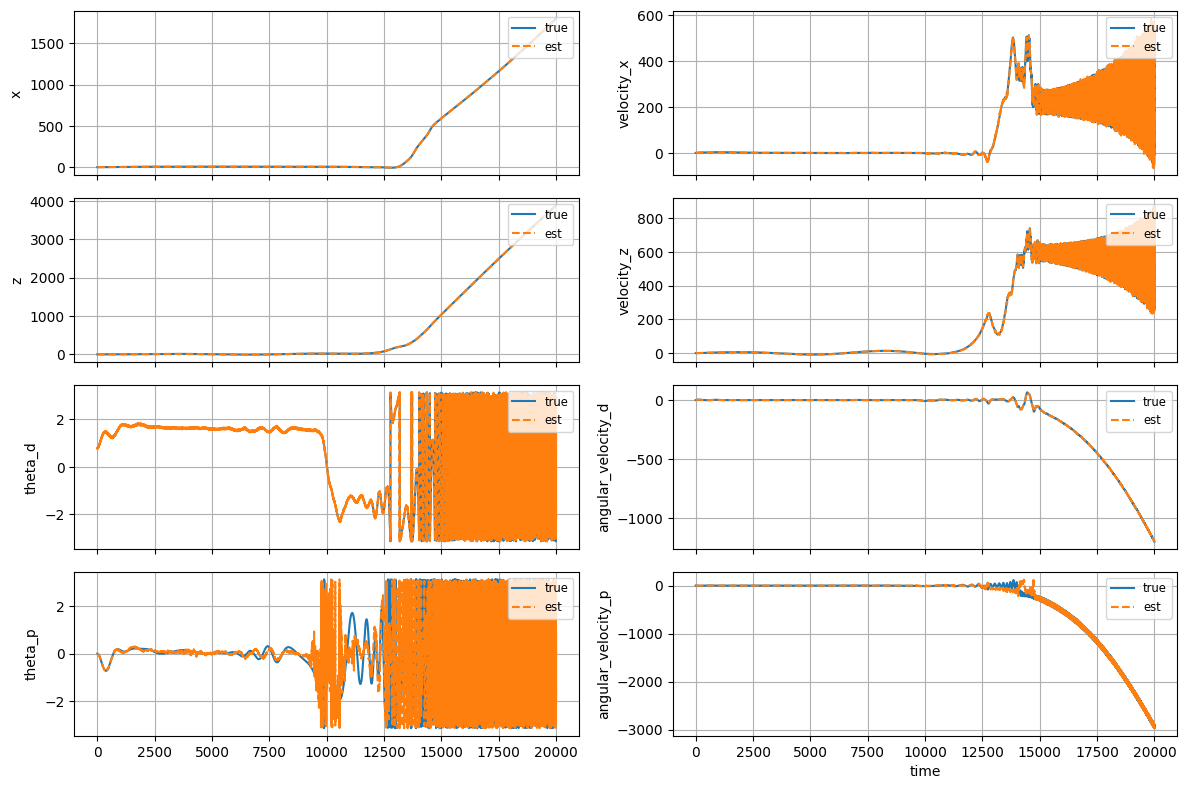

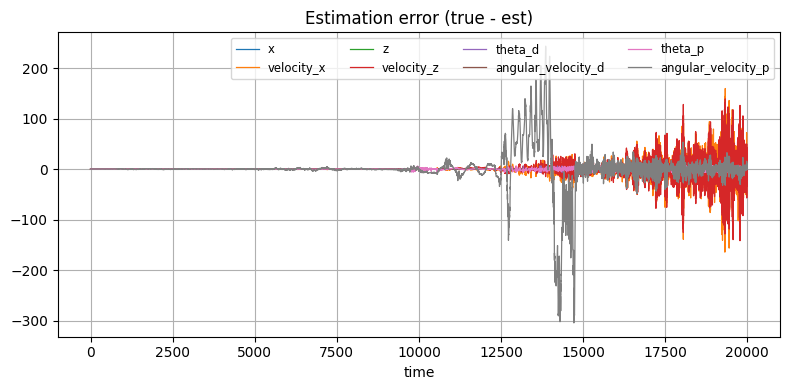

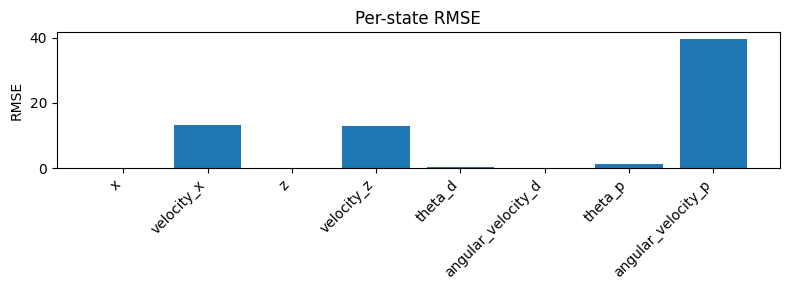

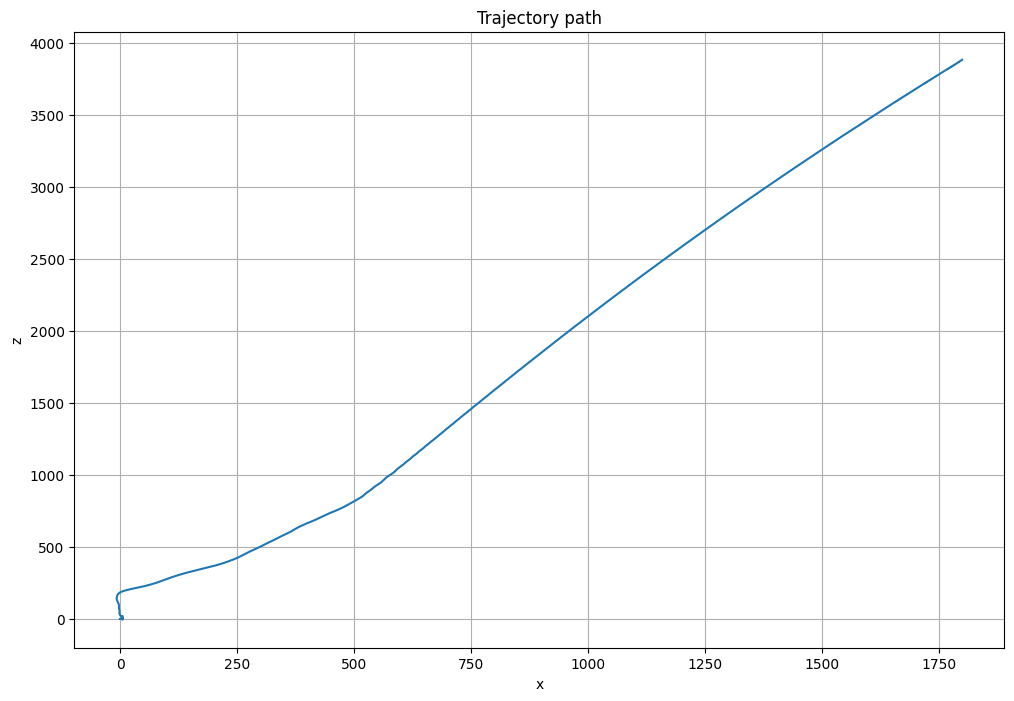

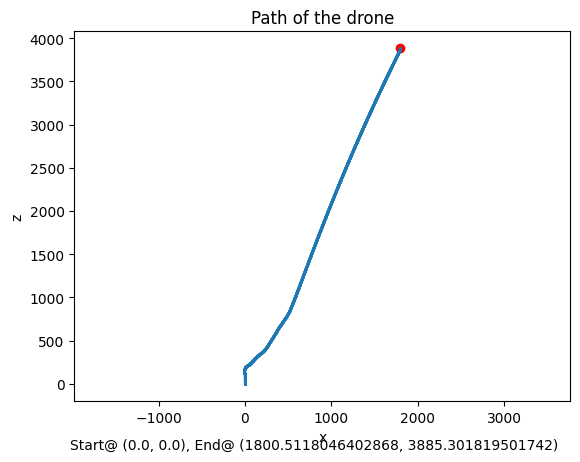

In [153]:
hist = np.array(hist)
hist_hat = np.array(hist_hat)

hist[:, 4] = np.arctan2(np.sin(hist[:, 4]), np.cos(hist[:, 4]))
hist[:, 6] = np.arctan2(np.sin(hist[:, 6]), np.cos(hist[:, 6]))

hist_hat[:, 4] = np.arctan2(np.sin(hist_hat[:, 4]), np.cos(hist_hat[:, 4]))
hist_hat[:, 6] = np.arctan2(np.sin(hist_hat[:, 6]), np.cos(hist_hat[:, 6]))


states_name = [
    "x",
    "velocity_x",
    "z",
    "velocity_z",
    "theta_d",
    "angular_velocity_d",
    "theta_p",
    "angular_velocity_p",
]

plot_state_history(hist, hist_hat, state_names=states_name, plot_error=True)
plot_drone_path(hist[:, 0], hist[:, 2])